Appending Data to xarray.Datasets
================================

When working with scientific data, you'll often need to combine or append datasets from different experiments or measurements. This tutorial demonstrates various methods to append data to existing xarray.Dataset objects, with a focus on scattering and composition data.



Setup
-----


## Google Colab Setup

Only uncomment and run the next cell if you are running this notebook in Google Colab or if don't already have the AFL-agent package installed.

In [ ]:
# !pip install git+https://github.com/usnistgov/AFL-agent.git

Next, let's import the necessary support modules and load data from AFL.double_agent

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

print(f"xarray version: {xr.__version__}")

# Import the example dataset from AFL.double_agent.data
from AFL.double_agent.data import example_dataset1

# Load the example dataset
ds = example_dataset1()

# Print basic information about the dataset
print(f"Dataset dimensions: {dict(ds.sizes)}")
print(f"Dataset variables: {list(ds.data_vars)}")
print(f"Dataset coordinates: {list(ds.coords)}")

xarray version: 2025.1.2
Dataset dimensions: {'sample': 100, 'component': 2, 'x': 150, 'grid': 2500}
Dataset variables: ['composition', 'ground_truth_labels', 'measurement', 'composition_grid']
Dataset coordinates: ['component', 'x']


Understanding the Dataset
------------------------

Let's first understand the structure of our example dataset:

In [3]:
# Look at the composition data
print("Composition data shape:", ds.composition.shape)
print("Sample of composition data:")
ds.composition.isel(sample=slice(0, 3))

Composition data shape: (100, 2)
Sample of composition data:


<xarray.DataArray 'composition' (sample: 3, component: 2)> Size: 48B
[6 values with dtype=float64]
Coordinates:
  * component  (component) <U1 8B 'A' 'B'
Dimensions without coordinates: sample

The composition data has dimensions ('sample', 'component') with 100 samples and 2 components.

In [4]:
# Look at the measurement data
print("Measurement data shape:", ds.measurement.shape)
print("Sample of measurement data:")
ds.measurement.isel(sample=slice(0, 2), x=slice(0, 5))

Measurement data shape: (100, 150)
Sample of measurement data:


<xarray.DataArray 'measurement' (sample: 2, x: 5)> Size: 80B
[10 values with dtype=float64]
Coordinates:
  * x        (x) float64 40B 0.001 0.001047 0.001097 0.001149 0.001204
Dimensions without coordinates: sample

The measurement data has dimensions ('sample', 'x') with 100 samples and 150 x-values.

Text(0.5, 1.0, 'Measurement Data for First 3 Samples')

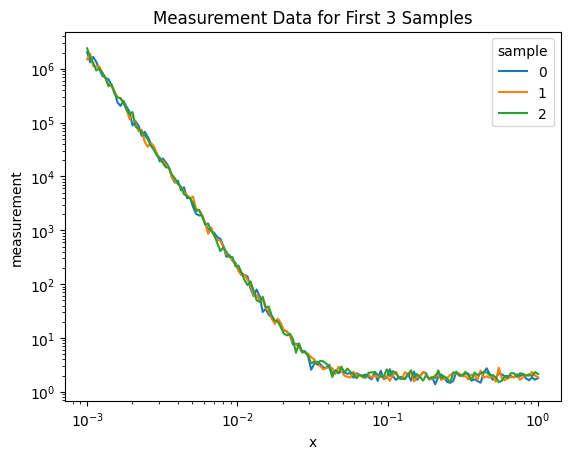

In [5]:
# Plot measurements for the first 3 samples using xarray's built-in plotting
ds.measurement.isel(sample=slice(0, 3)).plot.line(x='x', hue='sample', xscale='log',yscale='log')

plt.title('Measurement Data for First 3 Samples')

Creating Subsets of the Dataset
------------------------------

To demonstrate appending data, let's first create subsets of our dataset:

In [6]:
# Create two subsets of the data
ds_batch1 = ds.isel(sample=slice(0, 50))  # First 50 samples
ds_batch2 = ds.isel(sample=slice(50, 100))  # Last 50 samples

print(f"Batch 1: {ds_batch1.sizes}")
print(f"Batch 2: {ds_batch2.sizes}")

Batch 1: Frozen({'sample': 50, 'component': 2, 'x': 150, 'grid': 2500})
Batch 2: Frozen({'sample': 50, 'component': 2, 'x': 150, 'grid': 2500})


Method 1: Concatenating Along the Sample Dimension
-------------------------------------------------

The most common way to append datasets is using ``xr.concat()`` to combine along a dimension. Here, we'll combine our two batches along the sample dimension:

In [7]:
# Concatenate along the sample dimension
combined_ds = xr.concat([ds_batch1, ds_batch2], dim='sample')

print("Combined dataset dimensions:", combined_ds.sizes)

# Verify that the combined dataset has the same number of samples as the original
print(f"Original samples: {ds.sizes['sample']}")
print(f"Combined samples: {combined_ds.sizes['sample']}")

# Check if the data is the same
print("Data is identical:", np.allclose(ds.measurement.values, combined_ds.measurement.values))

Combined dataset dimensions: Frozen({'sample': 100, 'component': 2, 'x': 150, 'grid': 2500})
Original samples: 100
Combined samples: 100
Data is identical: True


The combined dataset has the same dimensions as our original dataset, and the data is identical.

Let's visualize the combined data:

Text(0.5, 1.0, 'Samples from Combined Dataset')

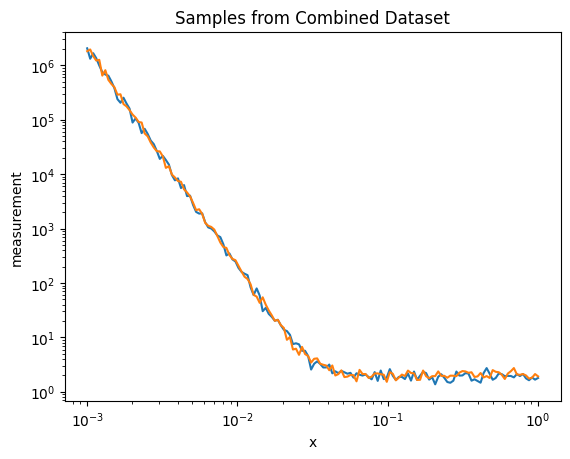

In [8]:
# Plot using xarray's built-in plotting functionality
combined_ds.measurement.isel(sample=0).plot( label="First sample (Batch 1)",xscale='log',yscale='log')
combined_ds.measurement.isel(sample=50).plot( label="First sample (Batch 2)",xscale='log',yscale='log')

plt.title('Samples from Combined Dataset')

Method 2: Adding New Variables to Existing Datasets
--------------------------------------------------

Sometimes you might want to add new variables to an existing dataset, such as adding derived data or analysis results.

Let's create a new variable by calculating the mean of each measurement:

In [9]:
# Calculate the mean of each measurement
measurement_mean = ds_batch1.measurement.mean(dim='x')


# Create a new dataset with this information
mean_ds = xr.Dataset()
mean_ds['measurement_mean'] = ('sample', measurement_mean.values)
mean_ds


<xarray.Dataset> Size: 400B
Dimensions:           (sample: 50)
Dimensions without coordinates: sample
Data variables:
    measurement_mean  (sample) float64 400B 8.046e+04 7.622e+04 ... 7.786e+04

Now we can merge this new dataset with our original batch:

Merged dataset variables: ['composition', 'ground_truth_labels', 'measurement', 'composition_grid', 'measurement_mean']


Text(0.5, 1.0, 'Measurements and Their Means')

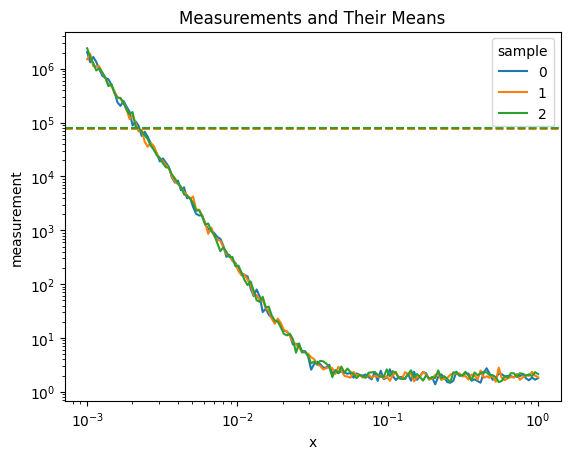

In [14]:
# Merge the mean dataset with batch1
merged_ds = xr.merge([ds_batch1, mean_ds])

print("Merged dataset variables:", list(merged_ds.data_vars))

# Plot the original measurements and their means
merged_ds.measurement.isel(sample=[0,1,2]).plot.line(x='x', hue='sample', xscale='log',yscale='log')
for i in range(3):
    plt.axhline(y=merged_ds.measurement_mean.isel(sample=i), linestyle='--', color=f'C{i}', label=f"Mean of Sample {i}")

plt.title('Measurements and Their Means')

Method 3: Combining Datasets with Different X Ranges
---------------------------------------------------

Sometimes you need to combine datasets with different x ranges. Let's create a subset with a different x range:

In [ ]:
# Create a subset with a different x range
x_subset = ds.x.values[::2]  # Take every other x value

# Create a new dataset with this subset
ds_subset_x = ds.isel(sample=slice(0, 10)).copy()  # First 10 samples

# Interpolate the data to the new x values
new_measurement = np.zeros((10, len(x_subset)))

for i in range(10):
    new_measurement[i] = np.interp(
        x_subset, 
        ds.x.values, 
        ds.measurement.isel(sample=i).values
    )

# Create the new dataset
ds_different_x = xr.Dataset(
    data_vars={
        'measurement': (('sample', 'x'), new_measurement),
        'composition': ds_subset_x.composition.values,
    },
    coords={
        'sample': ds_subset_x.sample,
        'x': x_subset,
        'component': ds.component,
    }
)

print("Original x length:", len(ds.x))
print("New x length:", len(ds_different_x.x))

To combine datasets with different x coordinates, we need to interpolate onto a common grid:

In [ ]:
# Get a sample from each dataset
sample_original = ds.isel(sample=0)
sample_different_x = ds_different_x.isel(sample=0)

# Plot to show the different x grids
plt.figure(figsize=(10, 6))

plt.plot(sample_original.x, sample_original.measurement, 
         'o-', label="Original x grid")
plt.plot(sample_different_x.x, sample_different_x.measurement, 
         'x-', label="Different x grid")

plt.xlabel('x')
plt.ylabel('Measurement')
plt.title('Comparison of Different X Grids')
plt.legend()
plt.tight_layout()
plt.show()

To combine these datasets, we need to interpolate one onto the grid of the other:

In [ ]:
# Create a combined x grid (union of both)
combined_x = np.sort(np.unique(np.concatenate([
    ds.x.values, 
    ds_different_x.x.values
])))

# Interpolate both datasets to this new grid
# For demonstration, we'll just use one sample from each

# Interpolate original data
original_interp = np.interp(
    combined_x, 
    ds.x.isel(sample=0), 
    ds.measurement.isel(sample=0)
)

# Interpolate different_x data
different_x_interp = np.interp(
    combined_x, 
    ds_different_x.x.isel(sample=0), 
    ds_different_x.measurement.isel(sample=0)
)

# Create a new dataset with the combined x grid
combined_x_ds = xr.Dataset(
    data_vars={
        'measurement_original': ('x', original_interp),
        'measurement_different_x': ('x', different_x_interp),
    },
    coords={
        'x': combined_x,
    }
)

print("Combined x grid length:", len(combined_x_ds.x))

# Plot the interpolated data
plt.figure(figsize=(10, 6))

plt.plot(combined_x_ds.x, combined_x_ds.measurement_original, 
         label="Original data (interpolated)")
plt.plot(combined_x_ds.x, combined_x_ds.measurement_different_x, 
         label="Different x data (interpolated)")

plt.xlabel('x')
plt.ylabel('Measurement')
plt.title('Data Interpolated to Common X Grid')
plt.legend()
plt.tight_layout()
plt.show()

Method 4: Filling Missing Data
-------------------------------

Sometimes you might have incomplete data that needs to be filled from another dataset:

In [ ]:
# Create a dataset with some missing values
ds_with_nans = ds.isel(sample=slice(0, 10)).copy()

# Set some measurement values to NaN
measurement_with_nans = ds_with_nans.measurement.values.copy()
measurement_with_nans[2:5, 30:60] = np.nan  # Set a block to NaN

ds_with_nans['measurement'] = (('sample', 'x'), measurement_with_nans)

# Visualize the dataset with missing values
plt.figure(figsize=(10, 6))

for i in range(3):
    plt.plot(ds_with_nans.x, ds_with_nans.measurement.isel(sample=i), 
             label=f"Sample {i}")

plt.xlabel('x')
plt.ylabel('Measurement')
plt.title('Dataset with Missing Values')
plt.legend()
plt.tight_layout()
plt.show()

We can use the ``combine_first()`` method to fill missing values from another dataset:

In [ ]:
# Create a dataset to fill the missing values
# We'll use the original dataset for this
ds_fill = ds.isel(sample=slice(0, 10))

# Fill the missing values
ds_filled = ds_with_nans.combine_first(ds_fill)

# Check if all NaNs are filled
print("NaNs in original:", np.isnan(ds_with_nans.measurement.values).sum())
print("NaNs after filling:", np.isnan(ds_filled.measurement.values).sum())

# Visualize the filled dataset
plt.figure(figsize=(10, 6))

for i in range(3):
    plt.plot(ds_filled.x, ds_filled.measurement.isel(sample=i), 
             label=f"Sample {i} (filled)")
    
    # Also plot the original data with NaNs for comparison
    if i == 2:  # Sample 2 had NaNs
        plt.plot(ds_with_nans.x, ds_with_nans.measurement.isel(sample=i), 
                 'r--', label=f"Sample {i} (with NaNs)")

plt.xlabel('x')
plt.ylabel('Measurement')
plt.title('Dataset After Filling Missing Values')
plt.legend()
plt.tight_layout()
plt.show()

Method 5: Updating Metadata When Combining Datasets
----------------------------------------------------

When combining datasets, you might want to update the metadata (attributes):

In [ ]:
# Combine datasets and update attributes
combined_ds = xr.concat([ds_batch1, ds_batch2], dim='sample')

# Update attributes
combined_ds.attrs = {
    'description': 'Combined dataset from two batches',
    'samples': f"{combined_ds.sizes['sample']} samples",
    'x_range': f"{combined_ds.x.values[0]:.3f} to {combined_ds.x.values[-1]:.3f}",
    'components': ', '.join([str(c.values) for c in combined_ds.component]),
    'created_date': pd.Timestamp.now().strftime('%Y-%m-%d'),
}

print("Combined Dataset Attributes:")
for key, value in combined_ds.attrs.items():
    print(f"{key}: {value}")

Best Practices and Considerations
-------------------------------

When appending data to xarray Datasets, keep these tips in mind:

1. **Dimension Alignment**: Ensure that dimensions you're not concatenating along have the same values.
2. **Data Types**: Check that variables have compatible data types before combining.
3. **Metadata**: Decide how to handle metadata (attributes) when combining datasets.
4. **Interpolation**: When combining data with different coordinate values, consider interpolation to a common grid.
5. **Units**: Ensure that data being combined has consistent units.
6. **Performance**: For very large datasets, consider using dask for parallel processing.

Conclusion
---------

In this tutorial, we've explored various methods to append data to xarray Datasets:

1. Using ``xr.concat()`` to combine datasets along a dimension
2. Using ``xr.merge()`` to add new variables to existing datasets
3. Combining datasets with different coordinate values through interpolation
4. Using ``combine_first()`` to fill missing data
5. Handling metadata when combining datasets

These techniques are essential for working with multiple batches of data, combining data from different sources, or extending your dataset with new samples or derived properties.

Further Reading
-------------

- `xarray Documentation on Combining Data <http://xarray.pydata.org/en/stable/combining.html>`_
- `Dask Integration with xarray <http://xarray.pydata.org/en/stable/dask.html>`_
- `xarray API Reference <http://xarray.pydata.org/en/stable/api.html>`_